# Importing Libraries 

In [18]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = all


import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.grid_search import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics


#Learning curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import validation_curve

/home/sohail/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Loading Data

In [16]:
trainDF = pd.read_csv('data/cs-training.csv', index_col=0)
# trainDF.head(10)
# trainDF.info()
trainDF = trainDF.dropna()
#can drop NaN values
trainDF = trainDF.dropna()

#Can use this for cross-validation
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
# for train_index, test_index in cv.split(trainDF):
#     print("TRAIN:", train_index, "TEST:", test_index)

# Data Visualization

/home/sohail/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/home/sohail/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
/home/sohail/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


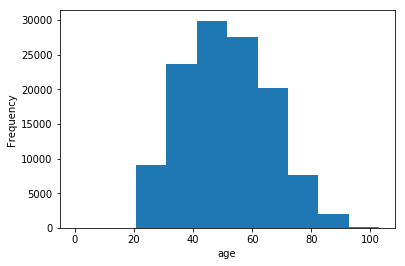

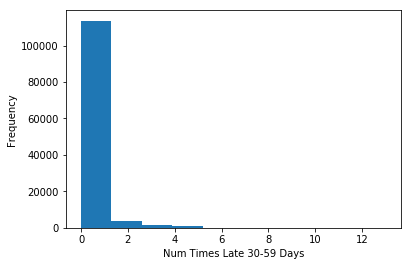

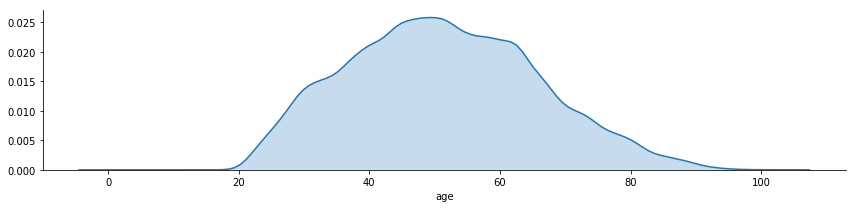

In [5]:
#Historam of Age
fig1 = plt.figure()
fig2 = plt.figure()
ax1 = fig1.add_subplot(1,1, 1) #1 rows, 1 column, 1st plot
ax2 = fig2.add_subplot(1,1, 1) #1 rows,1 column, 1st plot

n, bins, patches = ax1.hist(trainDF['age'])
ax1.set_xlabel('age')
ax1.set_ylabel('Frequency')
# fig1.savefig("hist_age.pdf", format='pdf')

trainDF.is_copy = False
trainDF['NumberOfTime30-59DaysPastDueNotWorse'].loc[(trainDF['NumberOfTime30-59DaysPastDueNotWorse']==98) 
    | (trainDF['NumberOfTime30-59DaysPastDueNotWorse']==96)] = trainDF['NumberOfTime30-59DaysPastDueNotWorse'].median()
#histogram of the NumberOfTime30-59DaysPastDueNotWorse
n, bins, patches = ax2.hist(trainDF['NumberOfTime30-59DaysPastDueNotWorse'])
ax2.set_xlabel('Num Times Late 30-59 Days')
ax2.set_ylabel('Frequency')
# fig2.savefig("hist_late.pdf", format='pdf')


#can also visualize data with KDE plot
#similar to histogram in that it treats each data point as Gaussian distribution
#and then takes cumulative probability function

# Set the figure equal to a facetgrid with the training set as data and change the aspect ratio
fig = sns.FacetGrid(trainDF, aspect=4)
# Next use map to plot all the possible kdeplots for the 'age' values
sns_plot = fig.map(sns.kdeplot,'age',shade= True)

# Data cleaning and more visualization

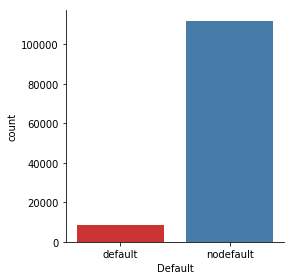

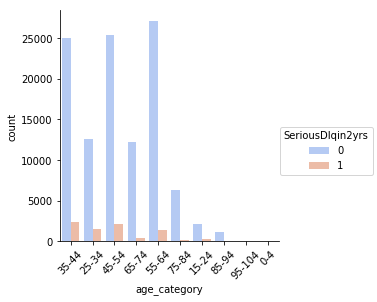

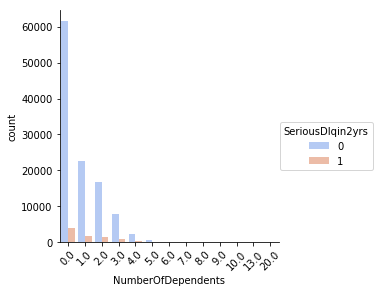

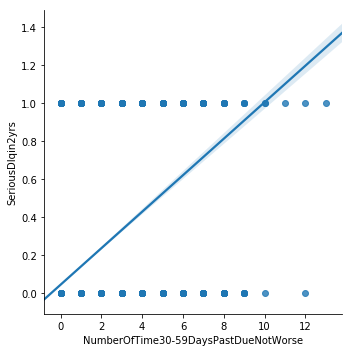

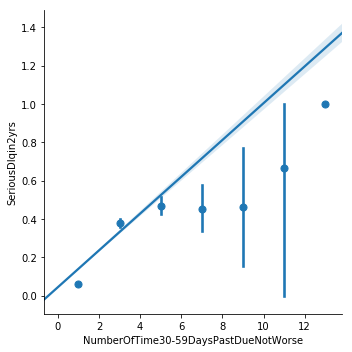

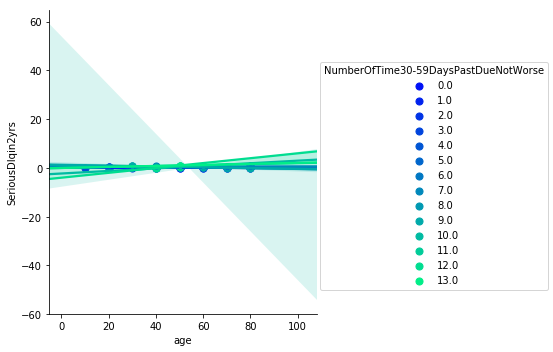

In [6]:
#see defaults vs nondefaults by creating new column called 'Default'
trainDF['Default'] = trainDF.SeriousDlqin2yrs.map({0:'nodefault', 1:'default'})
#truncate the age into nearest 10, 20, 30, 40 ...
trainDF['age_rounded'] = np.round(trainDF['age'],-1)
#categorize ages 0-5, 5-15, 15-25, ...
categories_dict = {0 : '0-4', 10 : '5-14', 20 : '15-24', 30: '25-34', 40: '35-44',
                    50 : '45-54',60 : '55-64', 70 : '65-74', 80 : '75-84',
          90 : '85-94',100 : '95-104', 110 : '105+'}
trainDF['age_category'] = trainDF['age_rounded'].map(categories_dict)

#Plot defaults
defaultplot = sns.factorplot('Default', data=trainDF, kind="count", palette='Set1')
# defaultplot.savefig("default.pdf",format="pdf")

#defaults vs age
defaultplot = sns.factorplot('age_category', data=trainDF, hue='SeriousDlqin2yrs',kind="count",palette='coolwarm')
defaultplot.set_xticklabels(rotation=45)
defaultplot.savefig("default_age.pdf",format="pdf")

#defaults vs # of dependents
defaultplot = sns.factorplot('NumberOfDependents', data=trainDF, hue='SeriousDlqin2yrs',kind="count",palette='coolwarm')
defaultplot.set_xticklabels(rotation=45)
# defaultplot.savefig("default_dependents.pdf",format="pdf")

#try to see if number of times borrower was 30-59days late in payment
#affected whether they defaulted or not
times=[1,3,5,7,9,11,13]
sns_plot=sns.lmplot('NumberOfTime30-59DaysPastDueNotWorse','SeriousDlqin2yrs',data=trainDF)
# sns_plot.savefig("late.pdf", format='pdf')
sns_plot=sns.lmplot('NumberOfTime30-59DaysPastDueNotWorse','SeriousDlqin2yrs',data=trainDF,palette='winter',x_bins=times)
# sns_plot.savefig("late_bins.pdf", format='pdf')

# # #can visualize this with linear plot
generations=[10,20,30,40,50,60,70, 80]
sns_plot =sns.lmplot('age','SeriousDlqin2yrs',hue='NumberOfTime30-59DaysPastDueNotWorse',data=trainDF,palette='winter',x_bins=generations)
# sns_plot.savefig("late_age_linear.pdf", format='pdf')

# Training models

In [7]:
#logistic regression
Y=trainDF.SeriousDlqin2yrs
# print ("Y.head is ", Y.head())
#need to convert this to 1-d array to use with scikit-learn
Y = np.ravel(Y)
# print ("Y is ", Y)
#Drop the extra columns that were created
X=trainDF.drop(['Default', 'age_category', 'age_rounded'], axis=1)
# print ("X.head is ", X.head())

log_model = LogisticRegression()
#log_model = log_model = LogisticRegression(C= .1, penalty='l1', tol=1e-6)
log_model.fit(X,Y)
#check accuracy
print ("accuracy is ", log_model.score(X,Y)) #mult by 100% to get %accuracy

#compare to null error rate, which is the % of people who defaulted
print ("Y.mean is ", Y.mean())
print ("1- Y.mean is ", 1-Y.mean())

#check coefficients of predictors to see which predictors were strongest
print(pd.DataFrame(np.transpose(log_model.coef_),X.columns))
#positive coefficient means an increase in likelihood of default, negative coef means decrease in default

accuracy is  0.9336321080245117
Y.mean is  0.06948590243537403
1- Y.mean is  0.930514097564626
                                             0
SeriousDlqin2yrs                      0.777518
RevolvingUtilizationOfUnsecuredLines -0.000155
age                                  -0.049063
NumberOfTime30-59DaysPastDueNotWorse  0.490655
DebtRatio                            -0.000177
MonthlyIncome                        -0.000049
NumberOfOpenCreditLinesAndLoans      -0.028669
NumberOfTimes90DaysLate               0.057642
NumberRealEstateLoansOrLines          0.071622
NumberOfTime60-89DaysPastDueNotWorse -0.111058
NumberOfDependents                    0.042053


In [8]:
#train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X,Y)
#this automatically splits them into training and test sets, 75% and 25% respectively

In [9]:
#regularization
cs = np.logspace(-5, 15, num=9) 
print ("cs: ", cs)

cs:  [1.00000000e-05 3.16227766e-03 1.00000000e+00 3.16227766e+02
 1.00000000e+05 3.16227766e+07 1.00000000e+10 3.16227766e+12
 1.00000000e+15]


# Grid Search

In [11]:
def grid_search_model(X, Y, model, parameters, cv):
    CV_model = GridSearchCV(estimator=model, param_grid=parameters, cv=cv)
    CV_model.fit(X, Y)
    CV_model.cv_results_
    print("Best Score:", CV_model.best_score_," / Best parameters:", CV_model.best_params_)

# Validation Curve

In [12]:
def validation_curve_model(X, Y, model, param_name, parameters, cv, ylim, log=True):

    train_scores, test_scores = validation_curve(model, X, Y, param_name=param_name, param_range=parameters,cv=cv, scoring="accuracy")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title("Validation curve")
    plt.fill_between(parameters, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(parameters, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1, color="g")

    if log==True:
        plt.semilogx(parameters, train_scores_mean, 'o-', color="r",label="Training score")
        plt.semilogx(parameters, test_scores_mean, 'o-', color="g",label="Cross-validation score")
    else:
        plt.plot(parameters, train_scores_mean, 'o-', color="r",label="Training score")
        plt.plot(parameters, test_scores_mean, 'o-', color="g",label="Cross-validation score")

    #plt.ylim([0.55, 0.9])
    if ylim is not None:
        plt.ylim(*ylim)

    plt.ylabel('Score')
    plt.xlabel('Parameter C')
    plt.legend(loc="best")
    
    return plt

# Learning Curve

In [13]:
def Learning_curve_model(X, Y, model, cv, train_sizes):

    plt.figure()
    plt.title("Learning curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")


    train_sizes, train_scores, test_scores = learning_curve(model, X, Y, cv=cv, n_jobs=4, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
                     
    plt.legend(loc="best")
    return plt

# Main Logic

NameError: name 'predict_model' is not defined

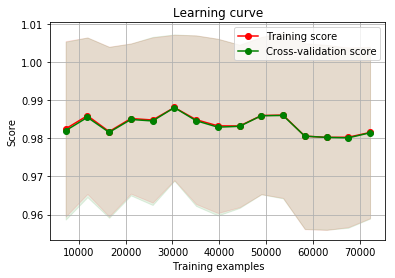

In [20]:
search_param = 0   # 1 -- grid search / 0 -- don't search
plot_vc      = 0   # 1--display validation curve/ 0-- don't display
plot_lc      = 1   # 1--display learning curve/ 0 -- don't display

#grid search: Logistic Regression
model = LogisticRegression()
if search_param==1:
    param_range = np.logspace(-6, 5, 12)
    param_grid = dict(C=param_range)
    grid_search_model(X_train, Y_train, model, param_grid, cv)

#Validation Curve: Logistic Regression
if plot_vc == 1:
    param_range = np.logspace(-6, 3, 10)
    param_name="C"
    ylim=[0.55, 0.9]
    validation_curve_model(X_train, Y_train, model, "C", param_range, cv, ylim)

#learn curve
logreg = LogisticRegression(C=1000)

if plot_lc==1:
    train_size=np.linspace(.1, 1.0, 15)
    Learning_curve_model(X_train, Y_train, logreg, cv, train_size)

